In [1]:
import numpy as np
import s3fs
import xarray as xr
import zarr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import datetime
import matplotlib.pyplot as plt

group_url    = 's3://hrrrzarr/sfc/20251205/20251205_00z_fcst.zarr/surface/PRATE'
subgroup_url = f'{group_url}/surface'


In [2]:
fs = s3fs.S3FileSystem(anon=True)

fcst_ds = xr.open_mfdataset(
    [s3fs.S3Map(u, s3=fs) for u in [group_url, subgroup_url]],
    engine='zarr',
    decode_timedelta=False,
    combine='by_coords',
)

fcst_ds

<xarray.Dataset> Size: 366MB
Dimensions:                  (time: 48, projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
  * time                     (time) datetime64[ns] 384B 2025-12-05T01:00:00 ....
Data variables:
    forecast_period          (time) int64 384B dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 8B ...
    PRATE                    (time, projection_y_coordinate, projection_x_coordinate) float32 366MB dask.array<chunksize=(48, 150, 150), meta=np.ndarray>

In [3]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                   globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))


fcst_ds = fcst_ds.rename(projection_x_coordinate='x', projection_y_coordinate='y')
fcst_ds = fcst_ds.metpy.assign_crs(projection.to_cf())
fcst_ds = fcst_ds.metpy.assign_latitude_longitude()
fcst_ds = fcst_ds.set_coords('time')
fcst_ds

<xarray.Dataset> Size: 396MB
Dimensions:                  (time: 48, x: 1799, y: 1059)
Coordinates:
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
  * time                     (time) datetime64[ns] 384B 2025-12-05T01:00:00 ....
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 15MB 21.14 21.15 ... 47.85 47.84
    longitude                (y, x) float64 15MB -122.7 -122.7 ... -60.95 -60.92
Data variables:
    forecast_period          (time) int64 384B dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 8B ...
    PRATE                    (time, y, x) float32 366MB dask.array<chunksize=(48, 150, 150), meta=np.ndarray>

In [4]:
prcp_nw_ds = fcst_ds.where(
    (fcst_ds.latitude >= 42) & (fcst_ds.latitude <= 49) &
    (fcst_ds.longitude >= -117) & (fcst_ds.longitude <= -111),
    drop=True,
)
prcp_nw_ds

<xarray.Dataset> Size: 34MB
Dimensions:                  (time: 48, y: 285, x: 201)
Coordinates:
  * x                        (x) float64 2kB -1.6e+06 -1.597e+06 ... -9.995e+05
  * y                        (y) float64 2kB 4.737e+05 4.767e+05 ... 1.326e+06
  * time                     (time) datetime64[ns] 384B 2025-12-05T01:00:00 ....
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 458kB 41.25 41.25 ... 49.67 49.68
    longitude                (y, x) float64 458kB -116.7 -116.7 ... -111.2
Data variables:
    forecast_period          (time, y, x) float64 22MB dask.array<chunksize=(48, 285, 201), meta=np.ndarray>
    forecast_reference_time  (y, x) datetime64[ns] 458kB NaT NaT NaT ... NaT NaT
    PRATE                    (time, y, x) float32 11MB dask.array<chunksize=(48, 132, 149), meta=np.ndarray>

In [5]:
prate = fcst_ds.PRATE

mask = (
    (fcst_ds.latitude >= 42) & (fcst_ds.latitude <= 49) &
    (fcst_ds.longitude >= -117) & (fcst_ds.longitude <= -111)
)

prate_nw = prate.where(mask, other=np.nan, drop=True)

In [6]:
prcp_nw_ds['PRATE_nan'] = prate_nw
prcp_nw_ds

<xarray.Dataset> Size: 45MB
Dimensions:                  (time: 48, y: 285, x: 201)
Coordinates:
  * x                        (x) float64 2kB -1.6e+06 -1.597e+06 ... -9.995e+05
  * y                        (y) float64 2kB 4.737e+05 4.767e+05 ... 1.326e+06
  * time                     (time) datetime64[ns] 384B 2025-12-05T01:00:00 ....
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 458kB 41.25 41.25 ... 49.67 49.68
    longitude                (y, x) float64 458kB -116.7 -116.7 ... -111.2
Data variables:
    forecast_period          (time, y, x) float64 22MB dask.array<chunksize=(48, 285, 201), meta=np.ndarray>
    forecast_reference_time  (y, x) datetime64[ns] 458kB NaT NaT NaT ... NaT NaT
    PRATE                    (time, y, x) float32 11MB dask.array<chunksize=(48, 132, 149), meta=np.ndarray>
    PRATE_nan                (time, y, x) float32 11MB dask.array<chunksize=(48, 132, 149), meta=np.ndarray>

In [10]:
fcst_prcp_nw = prcp_nw_ds.PRATE_nan.sum(dim='time', skipna=False) * 3600  # convert from kg/m2/s to mm/hr
fcst_prcp_nw

<xarray.DataArray 'PRATE_nan' (y: 285, x: 201)> Size: 229kB
dask.array<mul, shape=(285, 201), dtype=float32, chunksize=(153, 149), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 2kB -1.6e+06 -1.597e+06 ... -1.003e+06 -9.995e+05
  * y          (y) float64 2kB 4.737e+05 4.767e+05 ... 1.323e+06 1.326e+06
    metpy_crs  object 8B Projection: lambert_conformal_conic
    latitude   (y, x) float64 458kB 41.25 41.25 41.26 ... 49.67 49.67 49.68
    longitude  (y, x) float64 458kB -116.7 -116.7 -116.7 ... -111.2 -111.2

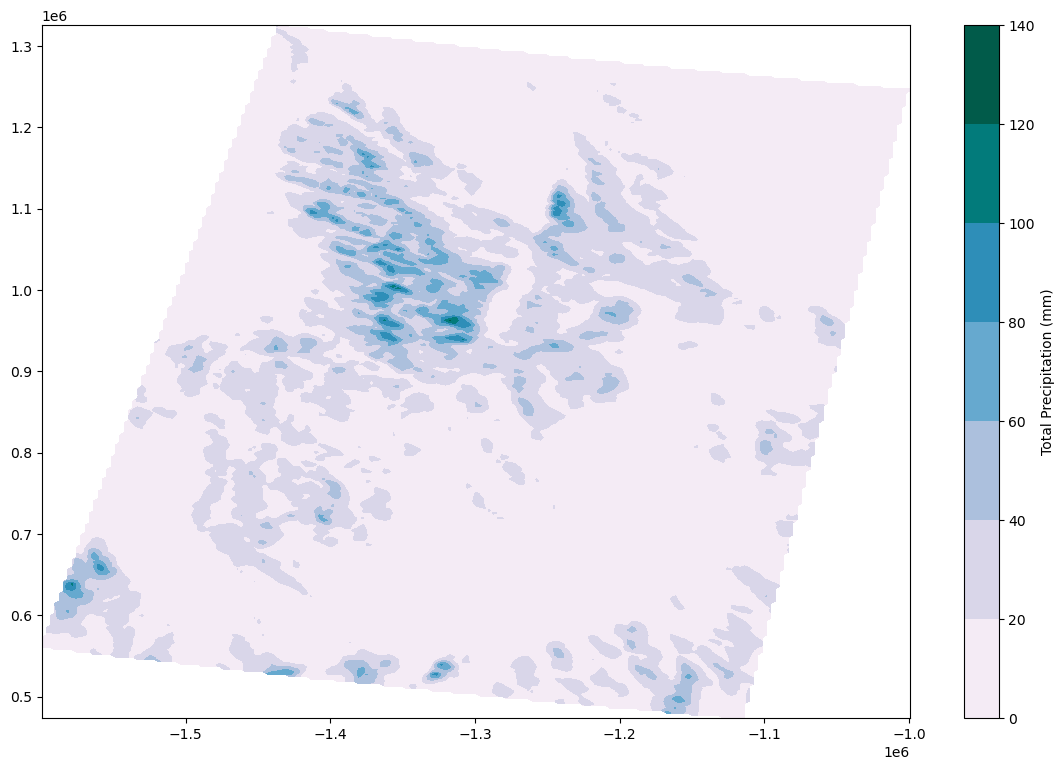

In [11]:
fig, ax = plt.subplots(figsize=(14, 9))

im = ax.contourf(fcst_prcp_nw.x, fcst_prcp_nw.y, fcst_prcp_nw, cmap='PuBuGn')

plt.colorbar(im, ax=ax, orientation='vertical', label='Total Precipitation (mm)')
plt.show()


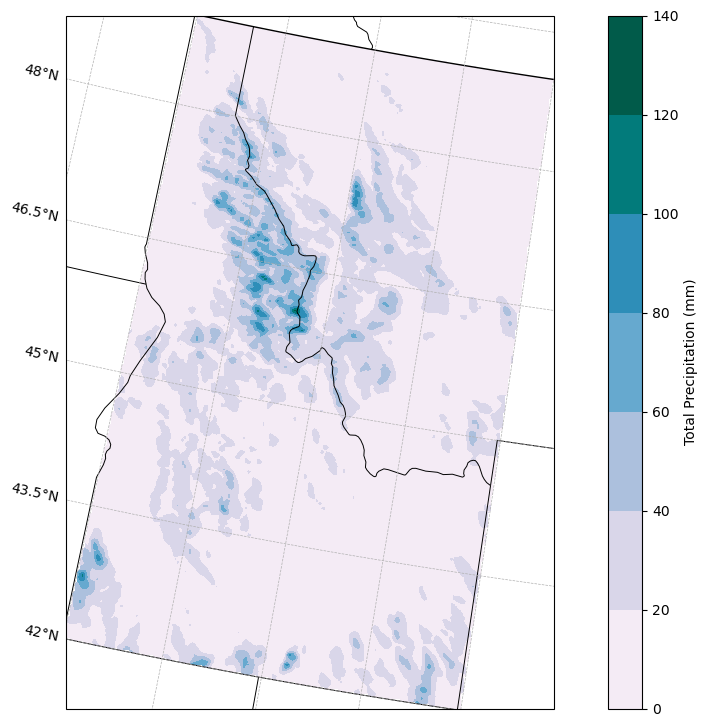

In [23]:
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

fig, ax = plt.subplots(figsize=(14, 9), subplot_kw={'projection': projection})

im = ax.contourf(
    fcst_prcp_nw.x, fcst_prcp_nw.y, fcst_prcp_nw,
    transform=projection,
    cmap='PuBuGn'
)

plt.colorbar(im, ax=ax, orientation='vertical', label='Total Precipitation (mm)')

# Add features
ax.add_feature(states, edgecolor='black', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=1.0)
ax.coastlines()

# -----------------------------
# Lat/lon gridlines + labels
# -----------------------------

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    linewidth=0.5,
    linestyle='--',
)

# Force labels only on bottom & left
# gl.top_labels = False
# gl.right_labels = False
gl.bottom_labels = True
gl.left_labels = True

# Formatting
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

plt.show()